In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
%load_ext autoreload
%autoreload 2

import pickle
import time
import tensorflow as tf
import numpy as np

from analysis import *

%matplotlib inline

In [3]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

Xtr = mnist.train.images.reshape(-1, 28, 28, 1)
Ytr = mnist.train.labels.astype(float)

Xtt = mnist.test.images.reshape(-1, 28, 28, 1)
Ytt = mnist.test.labels.astype(float)

num_classes = 10
val_set = {'X': Xtt[:500], 'Y': Ytt[:500]}
C2 = np.mean([np.sqrt(np.sum(np.square(i))) for i in Xtr])
gamma = 0.04*C2
eps_wrm = 1./(2*gamma)

eps_wrm = 1.3 # Note the above eps_wrm is 1.356, but we'll use 1.3 as used in the paper's code

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
from spectral_adversarial_regularization.models import elunet as model

arch = model.elunet
save_dir = os.path.join('save_weights_final', 'mnist', 'wrm')
train_network(Xtr, Ytr, val_set, arch, save_dir, eps=eps_wrm, adv='wrm', retrain=False)

Model already exists.. loading trained model..
INFO:tensorflow:Restoring parameters from save_weights_final/mnist/wrm/checkpoints/epoch200
Train acc: 1.00 (5.0 s elapsed)


In [5]:
# Estimate eps for the other samples using the perturbation achieved for each test sample
save_dir = os.path.join('save_weights_final', 'mnist', 'wrm')
arch = model.elunet

Xtr_adv_wrm = ad.build_graph_and_gen_adv_examples(Xtr, arch, save_dir, beta=1, num_channels=1,
                                                  load_epoch=25, method=ad.wrm, eps=eps_wrm)
    
eps = np.sqrt(np.mean([np.sum(np.square(i)) for i in Xtr_adv_wrm-Xtr])) 

eps = 0.05*C2 # Note: the above eps/C2 is 0.06, but we'll use 0.05 as seen in Figure 2a of the paper

INFO:tensorflow:Restoring parameters from save_weights_final/mnist/wrm/checkpoints/epoch25


In [6]:
arch = model.elunet
methods = ['erm', 'fgm', 'pgm']

for method in methods:
    save_dir = os.path.join('save_weights_final', 'mnist', method)
    train_network(Xtr, Ytr, val_set, arch, save_dir, eps=eps, adv=method, retrain=False)

Model already exists.. loading trained model..
INFO:tensorflow:Restoring parameters from save_weights_final/mnist/erm/checkpoints/epoch88
Train acc: 1.00 (3.1 s elapsed)
Model already exists.. loading trained model..
INFO:tensorflow:Restoring parameters from save_weights_final/mnist/fgm/checkpoints/epoch108
Train acc: 1.00 (3.2 s elapsed)
Model already exists.. loading trained model..
INFO:tensorflow:Restoring parameters from save_weights_final/mnist/pgm/checkpoints/epoch35
Train acc: 1.00 (3.1 s elapsed)


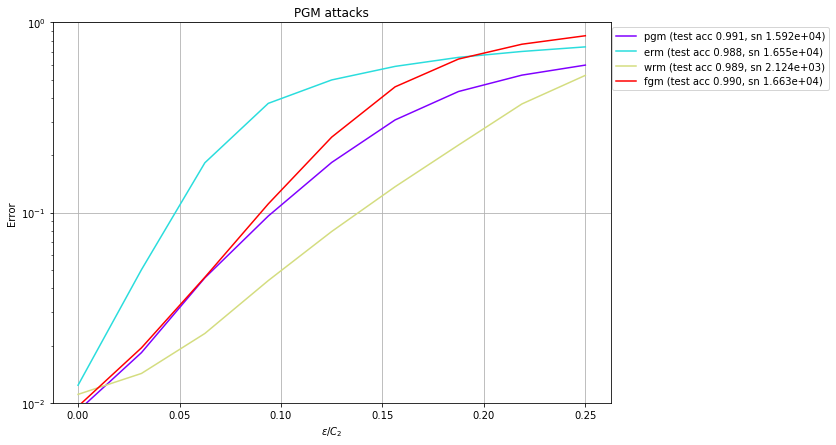

In [8]:
# Evaluate robustness of networks
eps_list = np.linspace(0, 0.25, 9)*C2
methods = ['erm', 'fgm', 'pgm', 'wrm']
curves_file = 'save_weights_final/mnist/adv_attack_curves_loadepoch25.pickle'

if os.path.isfile(curves_file):
    adv_results = pickle.load(file(curves_file, 'rb'))
else:
    adv_results = {}
    for method in methods:
        save_dir = os.path.join('save_weights_final', 'mnist', method)
        s_norm = dl_utils.get_overall_sn(save_dir, arch, num_channels=1, load_epoch=25)
        acc, adv_accs = get_adv_acc_curve(Xtt, Ytt, save_dir, arch, eps_list, load_epoch=25)
        adv_results[method] = (acc, adv_accs, s_norm)
    pickle.dump(adv_results, file(curves_file, 'wb'))
        
plot_acc_curves(adv_results, eps_list/C2)

INFO:tensorflow:Restoring parameters from save_weights_final/mnist/erm/checkpoints/epoch25
INFO:tensorflow:Restoring parameters from save_weights_final/mnist/erm/checkpoints/epoch25
INFO:tensorflow:Restoring parameters from save_weights_final/mnist/fgm/checkpoints/epoch25
INFO:tensorflow:Restoring parameters from save_weights_final/mnist/fgm/checkpoints/epoch25
INFO:tensorflow:Restoring parameters from save_weights_final/mnist/pgm/checkpoints/epoch25
INFO:tensorflow:Restoring parameters from save_weights_final/mnist/pgm/checkpoints/epoch25
INFO:tensorflow:Restoring parameters from save_weights_final/mnist/wrm/checkpoints/epoch25
INFO:tensorflow:Restoring parameters from save_weights_final/mnist/wrm/checkpoints/epoch25


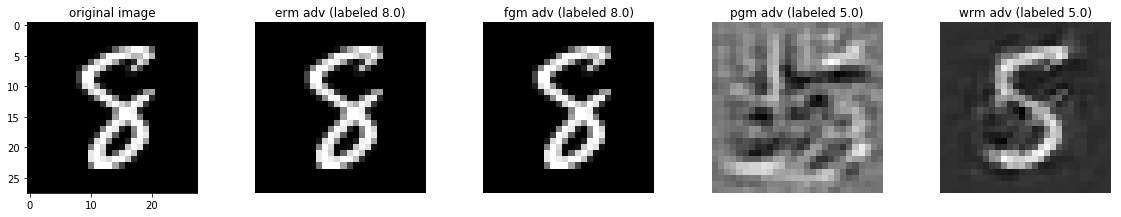

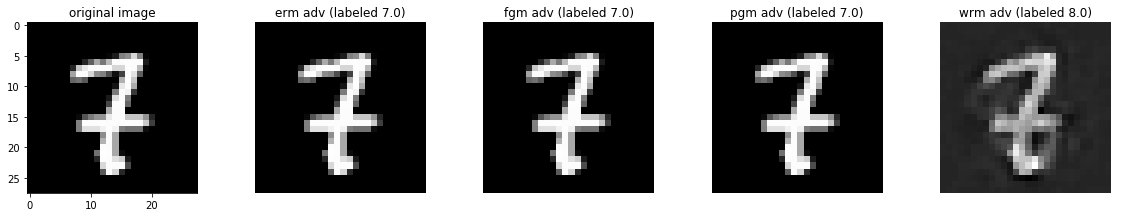

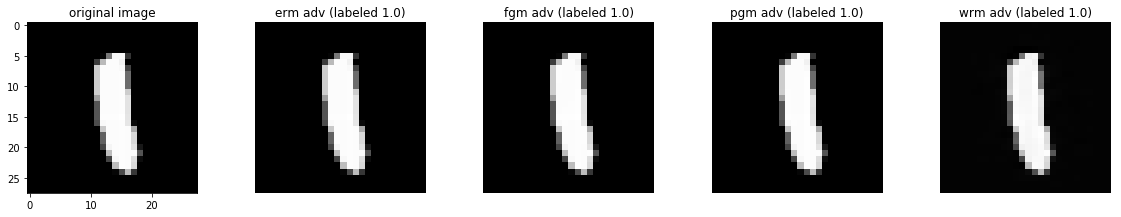

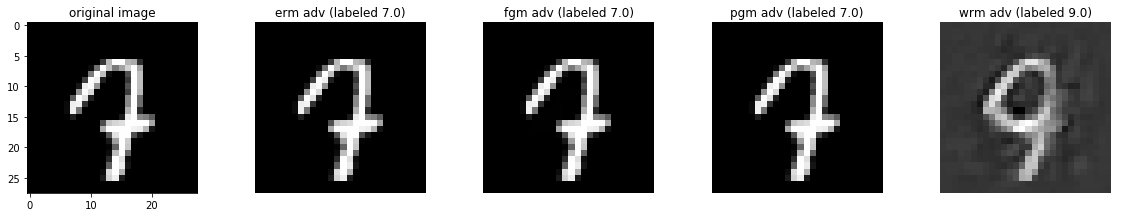

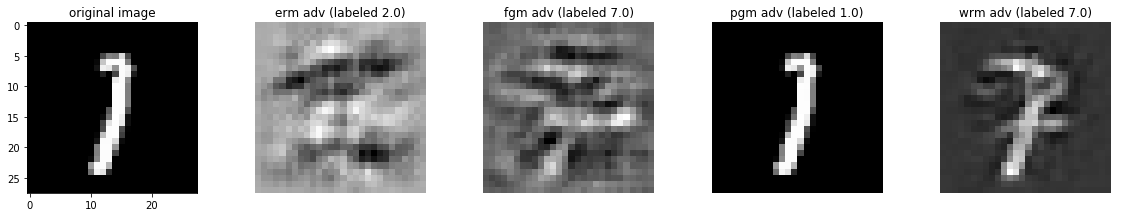

In [10]:
# Taking a closer look at some images after adversarial perturbation
eps = 0.3*C2

n = 5
np.random.seed(0)
ind_samp = np.random.choice(range(len(Xtt)), n, replace=False)
Xtt_samp = Xtt[ind_samp]

adv_examples = {}
for method in methods:
    save_dir = os.path.join('save_weights_final', 'mnist', method)
    X_adv = ad.build_graph_and_gen_adv_examples(Xtt_samp, arch, save_dir, num_channels=1,
                                                method=ad.wrm, eps=eps, order=2, load_epoch=25)
    Y_adv = dl_utils.build_graph_and_predict(X_adv, save_dir, arch, beta=1., num_channels=1, load_epoch=25)
    adv_examples[method] = (X_adv, Y_adv)
    
for i in range(n):
    plt.figure(figsize=(16, 3))
    plt.subplot(1, 5, 1)
    plt.imshow(Xtt_samp[i].reshape(28, 28), cmap='gray')
    plt.title('original image')
    for ii, method in enumerate(methods):
        plt.subplot(1, 5, ii+2)
        plt.imshow(adv_examples[method][0][i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title('%s adv (labeled %s)'%(method, adv_examples[method][1][i]))
    plt.tight_layout()
    plt.show()

# Testing spectral normalization

In [18]:
eps_list = np.linspace(0, 0.25, 9)*C2
methods = ['erm', 'fgm', 'pgm', 'wrm']

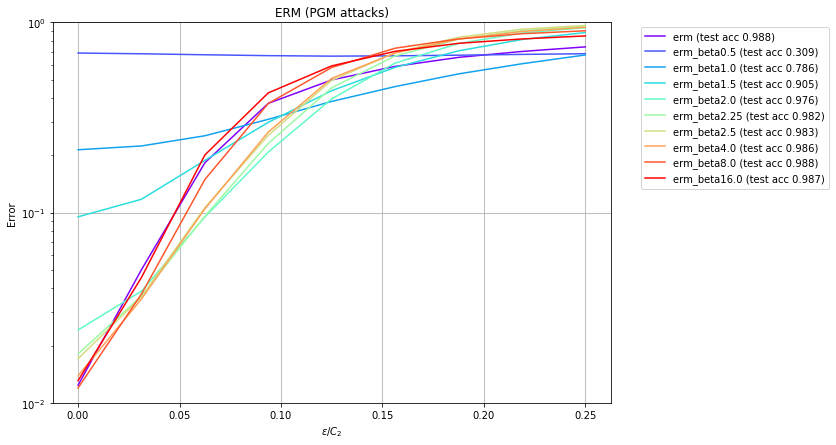

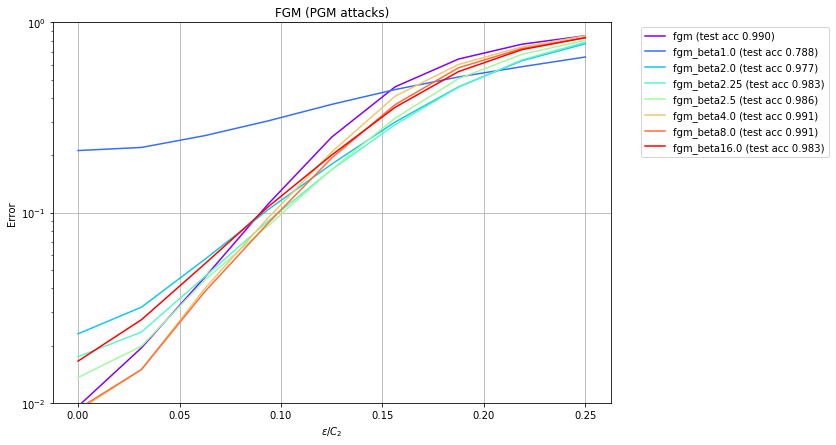

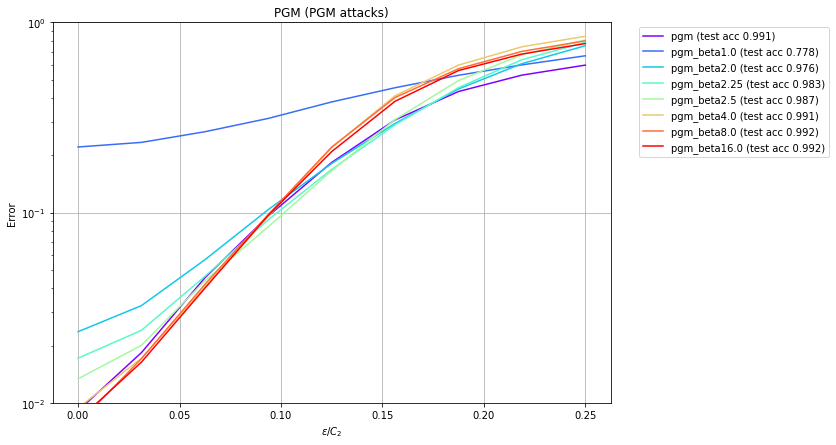

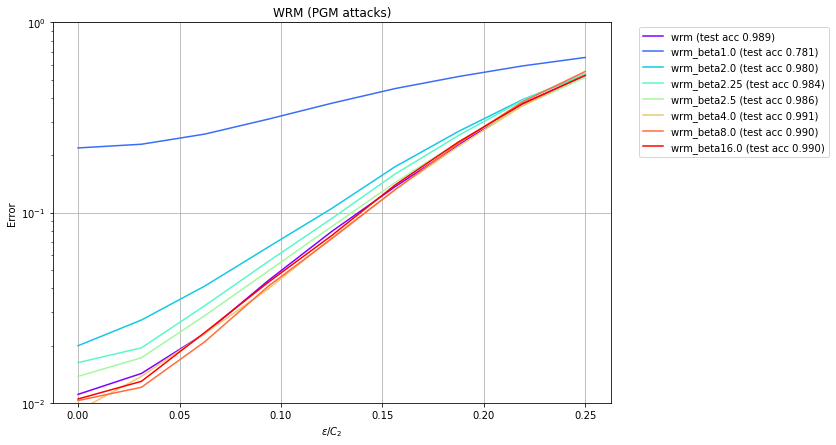

In [23]:
curves_file = 'save_weights_final/mnist/beta_adv_sweep_curves_loadepoch25.pickle'

if os.path.isfile(curves_file):
    all_beta_curves = pickle.load(file(curves_file, 'rb'))
else:
    all_beta_curves = {}
    for method in methods:
        all_beta_curves[method] = beta_sweep_curves(Xtt, Ytt, 'wrm', eps_list, model.elunet_sn,
                                                    model.elunet, load_epoch=25)
    pickle.dump(all_beta_curves, file(curves_file, 'wb'))

for method in methods:
    plot_acc_curves(all_beta_curves[method], eps_list/C2,
                    title='%s (PGM attacks)'%(method.upper()), sort_func=sort_func)

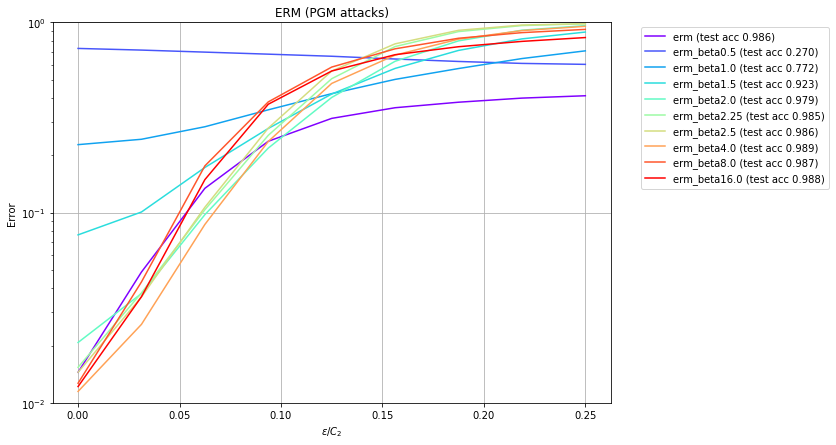

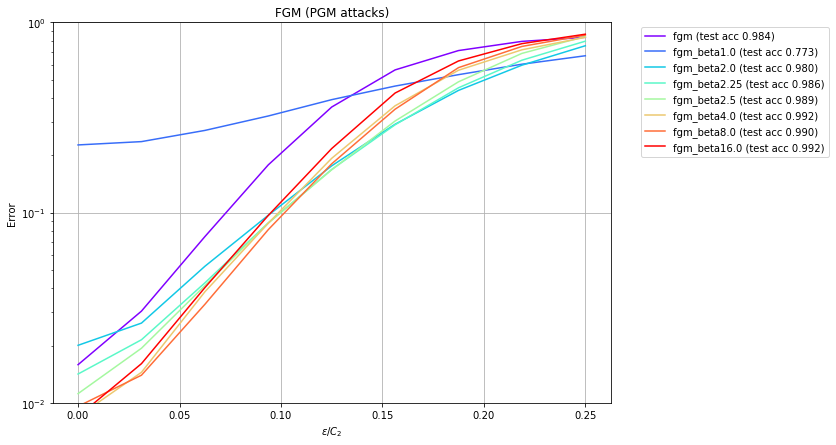

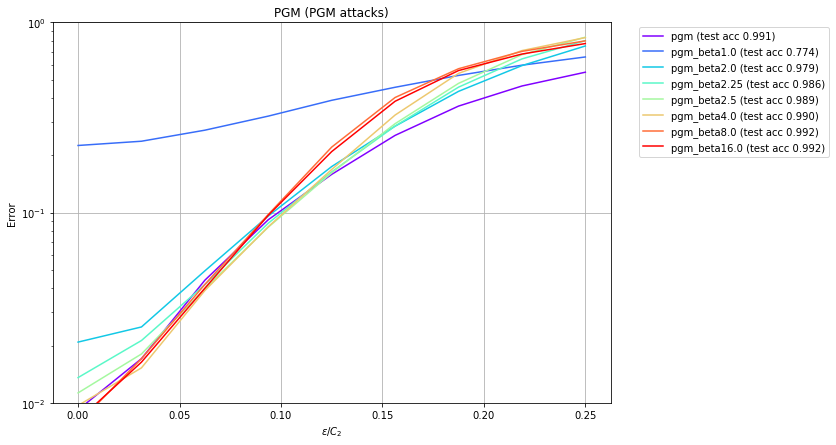

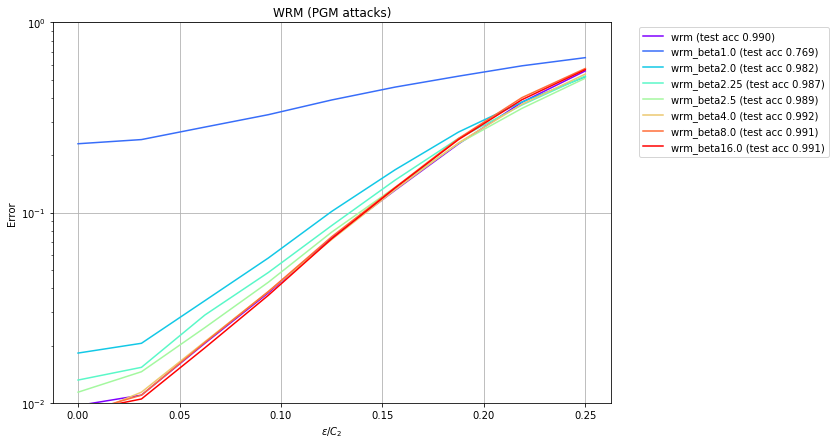

In [24]:
curves_file = 'save_weights_final/mnist/beta_adv_sweep_curves_loadepoch50.pickle'

if os.path.isfile(curves_file):
    all_beta_curves = pickle.load(file(curves_file, 'rb'))
else:
    all_beta_curves = {}
    for method in methods:
        all_beta_curves[method] = beta_sweep_curves(Xtt, Ytt, 'wrm', eps_list, model.elunet_sn,
                                                    model.elunet, load_epoch=50)
    pickle.dump(all_beta_curves, file(curves_file, 'wb'))

for method in methods:
    plot_acc_curves(all_beta_curves[method], eps_list/C2,
                    title='%s (PGM attacks)'%(method.upper()), sort_func=sort_func)